In [14]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## torch.script

torch.jit.script函数来转换模型，我们就有能力编译和优化多层感知机中的计算，而模型的计算结果保持不变。

**主要能转化的内容包括：**

1.  **`nn.Module` 子类**: 这是最常见的用例。你可以将整个模型类进行 script 化。
    ```python
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear = nn.Linear(10, 5)
        
        def forward(self, x):
            return torch.relu(self.linear(x))
            
    model = MyModel()
    scripted_model = torch.jit.script(model)
    ```

2.  **独立的 Python 函数**: 任何只使用 TorchScript 支持语法的函数都可以被转化。
    ```python
    def my_custom_activation(x):
        if x.mean() > 0:
            return torch.relu(x)
        else:
            return torch.tanh(x)

    scripted_fn = torch.jit.script(my_custom_activation)
    ```

3.  **大部分 PyTorch Tensor 操作**: 几乎所有的 `torch` 函数和 Tensor 方法都被支持。

4.  **数据依赖的控制流 (Data-dependent Control Flow)**: 这是 `torch.jit.script` 最强大的地方。它能理解代码中的 `if` 语句和 `for`/`while` 循环，并将这些逻辑编译到计算图中。
    *   **`if` 语句**: `if x.sum() > 0:`
    *   **`for` 循环**: `for i in range(x.shape[0]):`
    *   **循环的次数可以是动态的**: 比如循环次数依赖于输入张量的某个维度。

5.  **部分 Python 内置类型和操作**:
    *   **基本类型**: `int`, `float`, `bool`, `str`
    *   **数据结构**: `list`, `tuple`, `dict`
    *   **操作**: `len()`, `in` 操作符等。

---

In [15]:
class Benchmark:
    """用于测量运行时间"""
    def __init__(self, description='Done'):
        self.description = description

    def __enter__(self):
        self.timer = d2l.Timer()
        return self

    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [32]:
# 用sequential创建一个nn.Module对象
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2))
    return net
x = torch.randn(size=(1, 512))
net = get_net()

with Benchmark('无torchscript'):
    for i in range(1000): net(x)

net = torch.jit.script(net)
with Benchmark('有torchscript'):
    for i in range(1000): net(x)


无torchscript: 0.1302 sec
有torchscript: 0.1111 sec


## 异步计算

In [33]:
import os
import subprocess
import numpy
import torch
from torch import nn
from d2l import torch as d2l


| 代码块 | 同步方式 | 工作原理 | 结果 |
| :--- | :--- | :--- | :--- |
| `with d2l.Benchmark(): ... torch.cuda.synchronize()` | **显式/手动** | 程序员在 `with` 块内**手动**调用 `torch.cuda.synchronize()`。 | **正确** |
| `with d2l.Benchmark():` (无同步) | **无同步** | 完全没有等待GPU。 | **错误** |

1.  计时器启动。
2.  Python飞快地把任务扔给GPU，循环在几毫秒内完成。
3.  计时器立刻停止。
4.  **测量的结果会非常非常小，而且是完全错误的！** 因为它测量的仅仅是**Python提交任务所花费的时间**，而不是**GPU执行这些耗时任务的真正时间**。

In [36]:
device = d2l.try_gpu()
a = torch.randn(size=(1000, 1000), device=device)
b = torch.mm(a, a)

with d2l.Benchmark('numpy'):
    for _ in range(10):
        a = numpy.random.normal(size=(1000, 1000))
        b = numpy.dot(a, a)


with d2l.Benchmark():
    for _ in range(10):
        a = torch.randn(size=(1000, 1000), device=device)
        b = torch.mm(a, a)
    torch.cuda.synchronize(device)

numpy: 0.2311 sec
Done: 0.0030 sec


## 多GPU训练

In [10]:
# 打印出 PyTorch 能检测到的 GPU 数量
gpu_count = torch.cuda.device_count()
print(f"可用的 GPU 数量: {gpu_count}")

可用的 GPU 数量: 1


In [2]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]
# 定义模型
'''
torch.mm 就是矩阵乘法
'''
def lenet(X, params):
    # weight (20,1,3,3)输出通道是20，输入通道为1，卷积核大小3*3
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    #print(h3.shape)# 应该是(batch_size,128)
    y_hat = torch.mm(h3, params[6]) + params[7]
    #print(y_hat.shape) #(batch_size,10)
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [3]:
def get_params(params, device):# 这里把所有参数放到device并需要计算梯度
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

def allreduce(data):#用gpu0作为中间量，所有gpu的值加到它那，然后再把它的值分给所有gpu
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)
'''
nn.parallel.scatter把数据在通道批量大小维度平分
输入是 X，devices为目标的列表
'''
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

In [4]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) #使用全尺寸的小批量
        

In [8]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    print(devices)
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

测试精度：0.83，4.3秒/轮，在[device(type='cuda', index=0)]


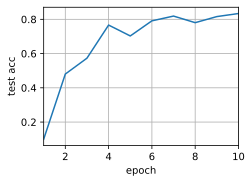

In [6]:
train(num_gpus=1, batch_size=256, lr=0.2)

[device(type='cuda', index=0), device(type='cpu')]


ValueError: Expected a non cpu device, but got: cpu

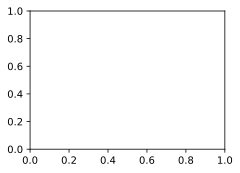

In [9]:
train(num_gpus=2, batch_size=256, lr=0.2)